### SeqGAN(字符级)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
#from google.colab import drive

print(f"Found GPU at: {tf.test.gpu_device_name()}.\nTensorFlow version: {tf.__version__}")

Found GPU at: /device:GPU:0.
TensorFlow version: 2.8.0


#### 输入格式

In [ ]:
text = ''
for sent in data[data['toxic'] == 1].iloc[:1000,:].comment_text.values:
    text = text + sent + '\r'

In [ ]:
text_set = set(text)
vocabulary = sorted(text_set)
VOCAB_SIZE = len(vocabulary)
char2idx = {u:i for i, u in enumerate(vocabulary)}
idx2char = np.array(vocabulary)

def one_hot(idx):
    oh = np.zeros(VOCAB_SIZE)
    oh[idx] = 1
    return oh

print("Vocabulary size:", VOCAB_SIZE)

Vocabulary size: 111


#### 超参数

In [ ]:
# batch size
BATCH_SIZE = 64
# number of RNN units
N_RNN_UNITS = 1024
# length of the training data for the discriminator
MAX_LENGTH = 32
# size of the embedding layer
EMBEDDING_DIM = 256

#### 创建训练数据

In [ ]:
vector_text = []
matrix_text = []
next_text = [] # for generator's pretraining
permuted_text = [] # for discriminator's pretraining
disc_label = [] # for discriminator's pretraining

In [ ]:
for c in range(0, len(text)-MAX_LENGTH, MAX_LENGTH):
    chunk = text[c : c + MAX_LENGTH]
    indices = [char2idx[i] for i in chunk]
    matrices = [one_hot(i) for i in indices]
    vector_text.append(indices)
    matrix_text.append(matrices)
    # for generator's pretraining
    next_chunk = text[c + 1 : c + 1 + MAX_LENGTH]
    next_text.append([char2idx[i] for i in next_chunk])
    # for discriminator's pretraining
    permuted = list(chunk)
    np.random.shuffle(permuted)
    permuted_text.append([one_hot(char2idx[i]) for i in permuted])
    permuted_text.append(matrices)
    disc_label += [0, 1]

print(np.array(vector_text).shape)
print(np.array(matrix_text).shape)
print(np.array(permuted_text).shape)
print(np.array(disc_label).shape)

(9119, 32)
(9119, 32, 111)
(18238, 32, 111)
(18238,)


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((vector_text, matrix_text))
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

N_TRAIN_BATCHES = len(dataset)

gen_dataset = tf.data.Dataset.from_tensor_slices((vector_text, next_text))
gen_dataset = gen_dataset.batch(BATCH_SIZE, drop_remainder=True)

disc_dataset = tf.data.Dataset.from_tensor_slices((permuted_text, disc_label))
disc_dataset = disc_dataset.batch(BATCH_SIZE, drop_remainder=True)

print(dataset)
print(gen_dataset)
print(disc_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(64, 32), dtype=tf.int32, name=None), TensorSpec(shape=(64, 32, 111), dtype=tf.float64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(64, 32), dtype=tf.int32, name=None), TensorSpec(shape=(64, 32), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(64, 32, 111), dtype=tf.float64, name=None), TensorSpec(shape=(64,), dtype=tf.int32, name=None))>


#### Generator

In [ ]:
#生成器模型（GRU）
def Generator(batch_size=BATCH_SIZE, vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, n_rnn_units=N_RNN_UNITS):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Embedding(
                vocab_size,
                embedding_dim,
                batch_input_shape=[batch_size, None]
            ),
            tf.keras.layers.GRU(
                n_rnn_units,
                return_sequences=True,
                stateful=True,
                recurrent_activation='sigmoid',
                recurrent_initializer='glorot_uniform'
            ),
            tf.keras.layers.Dense(vocab_size, activation="softmax")
        ]
    )
    return model

#损失函数
def gen_loss_function(labels, pred):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, pred)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           28416     
                                                                 
 gru_1 (GRU)                 (64, None, 1024)          3938304   
                                                                 
 dense_1 (Dense)             (64, None, 111)           113775    
                                                                 
Total params: 4,080,495
Trainable params: 4,080,495
Non-trainable params: 0
_________________________________________________________________


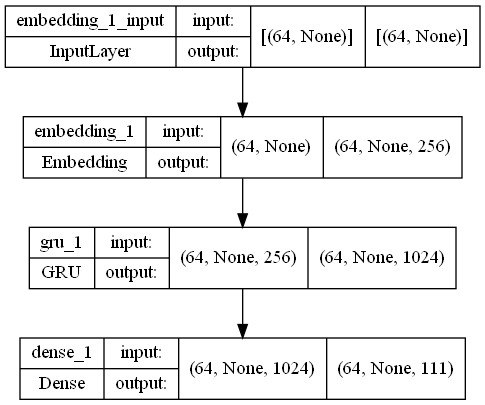

In [ ]:
from keras.utils.vis_utils import plot_model
lr = 1e-5
gen = Generator()
gen_optimizer = tf.keras.optimizers.Adam(lr)
gen.build((BATCH_SIZE, None, VOCAB_SIZE))
gen.summary()
plot_model(gen, to_file='C:/Users/25529/Downloads/gen.png',show_shapes=True)

#### Discriminator

In [ ]:
def Discriminator(vocab_size=VOCAB_SIZE, batch_size=BATCH_SIZE, embedding_dim=EMBEDDING_DIM):
    inp = tf.keras.Input((MAX_LENGTH, vocab_size), batch_size=batch_size)
    x = tf.keras.layers.Dense(embedding_dim, use_bias=False)(inp)
    sentence = tf.expand_dims(x, -1)
    x1 = tf.keras.layers.Conv2D(32, (3, embedding_dim), activation="relu")(sentence)
    x1 = tf.keras.layers.MaxPooling2D(pool_size=(MAX_LENGTH-2, 1))(x1)
    x2 = tf.keras.layers.Conv2D(32, (7, embedding_dim), activation="relu")(sentence)
    x2 = tf.keras.layers.MaxPooling2D(pool_size=(MAX_LENGTH-6, 1))(x2)
    x3 = tf.keras.layers.Conv2D(32, (11, embedding_dim), activation="relu")(sentence)
    x3 = tf.keras.layers.MaxPooling2D(pool_size=(MAX_LENGTH-10, 1))(x3)
    x4 = tf.keras.layers.Conv2D(32, (15, embedding_dim), activation="relu")(sentence)
    x4 = tf.keras.layers.MaxPooling2D(pool_size=(MAX_LENGTH-14, 1))(x4)
    x5 = tf.keras.layers.Conv2D(32, (19, embedding_dim), activation="relu")(sentence)
    x5 = tf.keras.layers.MaxPooling2D(pool_size=(MAX_LENGTH-18, 1))(x5)
    x6 = tf.keras.layers.Conv2D(32, (23, embedding_dim), activation="relu")(sentence)
    x6 = tf.keras.layers.MaxPooling2D(pool_size=(MAX_LENGTH-22, 1))(x6)
    conc = tf.keras.layers.Concatenate()([x1, x2, x3, x4, x5, x6])
    x = tf.squeeze(conc)
    x = tf.keras.layers.Dense(128)(x)
    y = tf.keras.layers.Dense(1)(x)
    y = tf.squeeze(y)
    model = tf.keras.Model(inputs=inp, outputs=y)
    return model

def disc_loss_function(labels, logits):
    return tf.keras.losses.binary_crossentropy(labels, logits, from_logits=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(64, 32, 111)]      0           []                               
                                                                                                  
 dense_2 (Dense)                (64, 32, 256)        28416       ['input_1[0][0]']                
                                                                                                  
 tf.expand_dims (TFOpLambda)    (64, 32, 256, 1)     0           ['dense_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (64, 30, 1, 32)      24608       ['tf.expand_dims[0][0]']         
                                                                                              

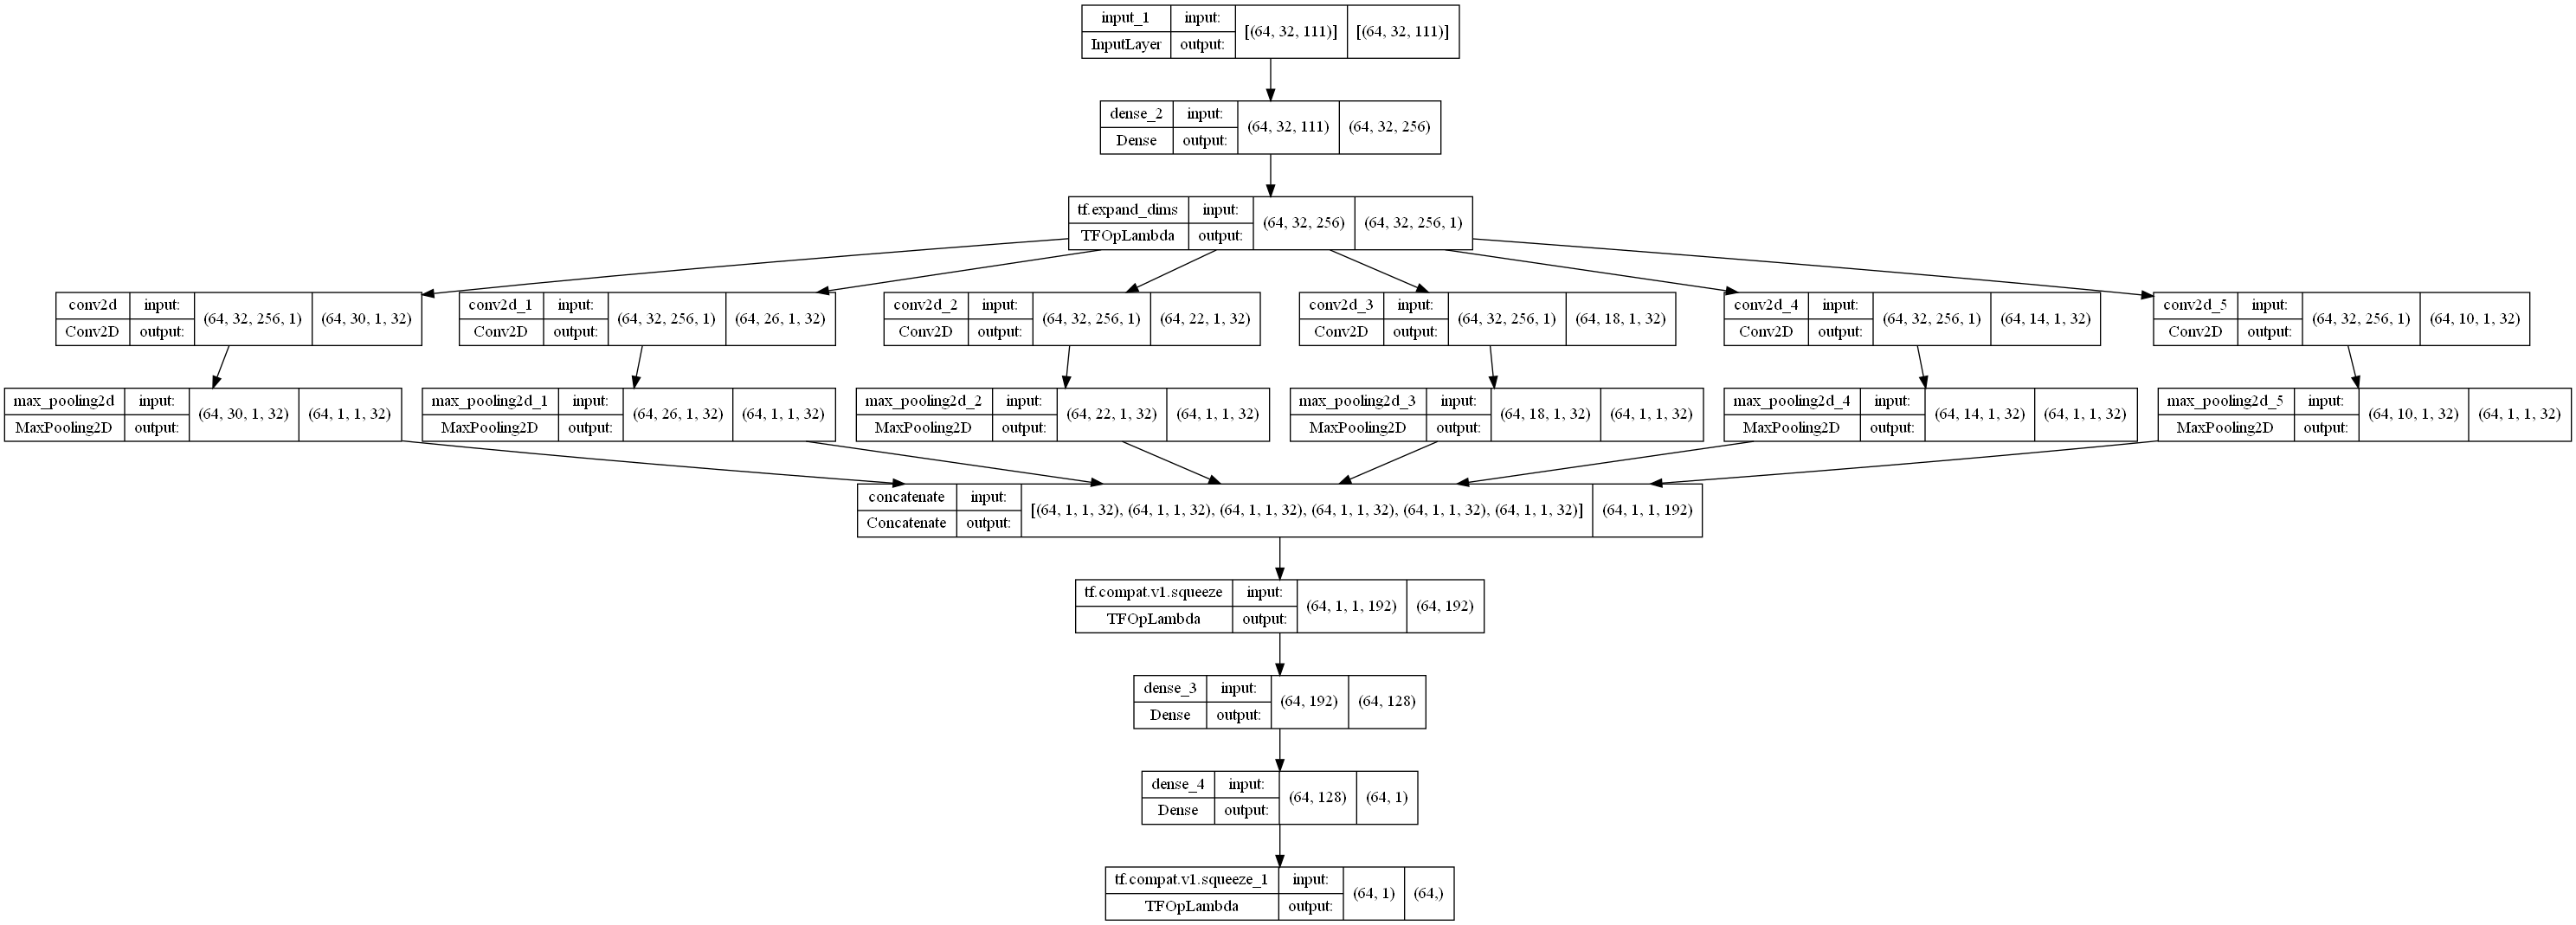

In [ ]:
lr = 1e-5
disc = Discriminator()
disc_optimizer = tf.keras.optimizers.Adam(lr)
disc.build((BATCH_SIZE, None, VOCAB_SIZE))
disc.summary()
plot_model(disc, to_file='C:/Users/25529/Downloads/disc.png',show_shapes=True)

#### GAN

In [ ]:
def gan_loss(logits, is_real=True):
    """
    Computes cross entropy between logits and labels
    """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)
    # Returns loss calculation
    return tf.nn.sigmoid_cross_entropy_with_logits(labels, logits)

In [ ]:
class GARNN(tf.keras.Model):
    """ 
    A basic GAN class. Extends tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GARNN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = self.gen
        self.disc = self.disc

    def call(self, x):
        return self.gen(x)

    def generate(self, z):
        """
        Run input vector z through the generator to create fake data.
        """
        return self.gen(z)

    def discriminate(self, x):
        """
        Run data through the discriminator to label it as real or fake.
        """
        return self.disc(x)

    def compute_loss(self, x):
        """ 
        Passes through the network and computes loss for given data.
        """
        vector = x[0]
        matrix = x[1]
        # Use the data to generate a fake data set with the generator network.
        self.gen.reset_states()
        fakes = self.generate(vector)

        # Use the discriminator network to obtain labels for both the generated data (x_gen) and the real data (x)
        logits_reals = self.discriminate(matrix)
        logits_fakes = self.discriminate(fakes)

        # Discriminator loss, looking at correctly labeled data
        # Losses of the real data with correct label "1"
        disc_real_loss = gan_loss(logits=logits_reals, is_real=True)
        # Losses of the fake data with correct label "0"
        disc_fake_loss = gan_loss(logits=logits_fakes, is_real=False)
        # The discriminator loss is the sum of the 2 previous values
        disc_loss = disc_fake_loss + disc_real_loss

        # Generator loss, looking at the fake data labeled as real ("1")
        gen_loss = gan_loss(logits=logits_fakes, is_real=True)

        # Return losses
        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ 
        Passes through the network and computes gradients.
        """
        ### Pass x through network and compute losses
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # Compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):
        """
        Apply given gradients to both networks.
        """
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.gen.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.disc.trainable_variables))

    @tf.function
    def train(self, train_x):
        """
        Train the GAN!
        """
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)

#### Train

In [ ]:
gen.compile(gen_optimizer, gen_loss_function)
n_epochs = 50
history = gen.fit(gen_dataset, epochs=n_epochs)

Epoch 1/50
160/160 [==============================] - 5s 11ms/step - loss: 4.8138
Epoch 2/50
160/160 [==============================] - 2s 10ms/step - loss: 4.1944
Epoch 3/50
160/160 [==============================] - 2s 10ms/step - loss: 3.6098
Epoch 4/50
160/160 [==============================] - 2s 10ms/step - loss: 3.5403
Epoch 5/50
160/160 [==============================] - 2s 10ms/step - loss: 3.5134
Epoch 6/50
160/160 [==============================] - 2s 10ms/step - loss: 3.4952
Epoch 7/50
160/160 [==============================] - 2s 10ms/step - loss: 3.4790
Epoch 8/50
160/160 [==============================] - 2s 10ms/step - loss: 3.4629
Epoch 9/50
160/160 [==============================] - 2s 10ms/step - loss: 3.4457
Epoch 10/50
160/160 [==============================] - 2s 10ms/step - loss: 3.4268
Epoch 11/50
160/160 [==============================] - 2s 10ms/step - loss: 3.4060
Epoch 12/50
160/160 [==============================] - 2s 10ms/step - loss: 3.3830
Epoch 13/50
1

In [ ]:
disc.compile(disc_optimizer, loss=disc_loss_function, metrics=['binary_accuracy'])
n_epochs = 5
history = disc.fit(disc_dataset, epochs=n_epochs)

Epoch 1/5
320/320 [==============================] - 16s 8ms/step - loss: 0.6748 - binary_accuracy: 0.5000
Epoch 2/5
320/320 [==============================] - 3s 8ms/step - loss: 0.5936 - binary_accuracy: 0.5700
Epoch 3/5
320/320 [==============================] - 3s 8ms/step - loss: 0.4669 - binary_accuracy: 0.7702
Epoch 4/5
320/320 [==============================] - 3s 8ms/step - loss: 0.3532 - binary_accuracy: 0.8676
Epoch 5/5
320/320 [==============================] - 3s 8ms/step - loss: 0.2745 - binary_accuracy: 0.9086


In [ ]:
model = GARNN(
    gen = gen,
    disc = disc,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer
)

n_epochs = 5

for epoch in range(1, n_epochs + 1):
    print("Epoch: {}".format(epoch))
    for batch, train_x in tqdm(zip(range(N_TRAIN_BATCHES), dataset), total=N_TRAIN_BATCHES):
        model.train(train_x)

Epoch: 1


100%|██████████| 160/160 [00:10<00:00, 15.98it/s]


Epoch: 2


100%|██████████| 160/160 [00:08<00:00, 19.71it/s]


Epoch: 3


100%|██████████| 160/160 [00:08<00:00, 19.51it/s]


Epoch: 4


100%|██████████| 160/160 [00:08<00:00, 19.47it/s]


Epoch: 5


100%|██████████| 160/160 [00:08<00:00, 19.34it/s]


#### Generate

In [ ]:
def generate_text(model, input_text, n_characters_output=1000):
    # First, vectorize the input text as before
    input_eval = [char2idx[s] for s in input_text]
    input_eval = tf.expand_dims(input_eval, 0)

    # We'll store results in this variable
    text_generated = []

    # Generate the number of characters desired
    model.reset_states()
    for i in range(n_characters_output):
        # Run input through model
        predictions = model(input_eval)

        # Remove the batch dimension
        predictions = predictions[0][-1]

        # Using argmax to predict the character returned by the model
        #predicted_id = np.argmax(predictions)
        predicted_id = tf.argsort(predictions, direction='DESCENDING')[3]

        # Pass the predicted character as the next input to the model
        input_eval = tf.expand_dims([predicted_id], 0)

        # Add the predicted character to the output
        text_generated.append(idx2char[predicted_id])

    # Return output
    return (input_text + ''.join(text_generated))

In [ ]:
gen.save('C:/Users/25529/Downloads/gen.h5')
gen = Generator(batch_size=1)
gen.load_weights('C:/Users/25529/Downloads/gen.h5')

In [ ]:
input_text = "Tony Sidaway is obviously"
n_output_characters = 96
output_text = generate_text(gen, input_text, n_output_characters)
print("Generated text:", output_text, sep='\n')

Generated text:
Tony Sidaway is obviouslyaULL1LL♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣♣†††††††††††††††††††††††††††††††††††ｏｏｏｏｏｏｏ………
